<a href="https://colab.research.google.com/github/harrisonp1223/CongressionalAnalytics/blob/main/GSB_521_Project_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greg Larmour
glarmour@calpoly.edu
# Harrison Pearce
hlpearce@calpoly.edu


GSB 521 - Pierce

8 February 2023

# Democrats vs. Republicans: 
## Who is more financially savvy? Who received more COVID Benefits?
##                  - The Questions We Want Answered -










# Introduction:

### 1. Are Democrats Or Republicans Better Investors?

Null Hypothesis: Democrats and Republicans, on average, are equally profitable Investors.

### 2. Did Democrats or Republicans Receive More COVID Unemployment Funding?

Null Hypothesis: Democrats and Republicans, on average, received an equal amount of unemployment funding during COVID.

In [3]:
import pandas as pd
import json
from urllib.request import urlopen
import matplotlib.pyplot as plt

# Data Collection

We will first collect data from the census on household incomes for every congressional district in each state. 

In [4]:
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001_001E,B19001_002E,B19001_017E&for=congressional%20district:*&in=state:*"
response = urlopen(url)
data_json = json.loads(response.read())
data_json.pop(0) 
cols = ['District Name','Total Households','Less than $10k', '$200k+', 'State code', 'district number']
acs_df = pd.DataFrame(data_json, columns = cols)
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])
acs_df['State'] = acs_df['State'].str.strip()
acs_df = acs_df[['Total Households', 'Less than $10k', "$200k+", 'district number', 'State']]
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
acs_df["Less than $10k"] = pd.to_numeric(acs_df["Less than $10k"])
acs_df['$200k+'] = pd.to_numeric(acs_df['$200k+'])
acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Total Households']
acs_df['% of households less than $10k'] = (100*acs_df['Less than $10k'])/acs_df['Total Households']

# Data Cleaning

We will clean our congressional income data below.

In [5]:
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() 
party_df = party_df[['State', 'Party', "district number"]]

In [6]:
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

We will now import our data from the Internal Revenue Service. The dataset from the Internal Revenue Service includes many interesting variables about the characteristics of each Congressional District. These include metrics such as gross income, total income, taxed income, number of returns, amounts of returns, along with many other variables. This Data Set includes information about the year 2020.


We would like to further explore the total capital gain (or loss) in each district in order to characterize the investing performance of congressional parties with differing political designations. 


We would then like to analyze the total unemployment compensation recieved per district in 2020, the COVID year where many Americans recieved unemployment checks due to their untimely unemployment. 

Finally, we will use the IRS Dataset to analyze the relationships between the variables of interest listed above with each district's total income. 

In [7]:
social_df = pd.read_csv("https://www.irs.gov/pub/irs-soi/20incd.csv")

Our data needs to be cleaned so we can merge it with our political party data set and our congressional income data set. This is done below by converting each State abbreviation to the state's full name.

In [8]:

state_abbr_to_name = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 
                     'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 
                     'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 
                     'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 
                     'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 
                     'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 
                     'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 
                     'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 
                     'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 
                     'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 
                     'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 
                     'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 
                     'WI': 'Wisconsin', 'WY': 'Wyoming'}
social_df['State'] = social_df['STATE'].map(state_abbr_to_name)
social_df['district number'] = social_df['CONG_DISTRICT']

In [9]:
merged_df_final = pd.merge(merged_df, social_df, on=["State", "district number"])                           
merged_df_final['Number of Farm Returns']  = merged_df_final["SCHF"]
merged_df_final['Net Capital Gain (Or Loss)']  = merged_df_final["A01000"]
merged_df_final["COVID Unemployment Compensation Amount"] = merged_df_final["A02300"]
merged_df_final['Total Income'] = merged_df_final['A02650']

In [45]:
merged_df_final['CONG_DISTRICT'] = merged_df_final['State'] + "_" + merged_df_final['CONG_DISTRICT'].astype(str)

agg_data = merged_df_final.groupby(['CONG_DISTRICT']).agg({'Total Income': 'sum', 
                                                           'COVID Unemployment Compensation Amount': 'sum', 
                                                           'Net Capital Gain (Or Loss)': 'sum', "Party": "first"})


filtered = agg_data["Party"] != "L"

agg_data = agg_data[filtered]


Above we have grouped by congressional district to better represent each district in terms of income. This is because the IRS dataset had segmented each district into income brackets, 9 of them with each indicating a gross income range / threshold. After creating a new variable that combined state with the congressional district number of that state we were able to group by congressional district and solve our segmentation issue.


Additionally, we removed the Libertarian party congressional districts due to a small samples size of n = 1. 

# PLOT 1 : Scatterplot of Net Capital Gain vs Total Income by Party

Net Capital Gain (Or Loss) Per District vs. Total District Income

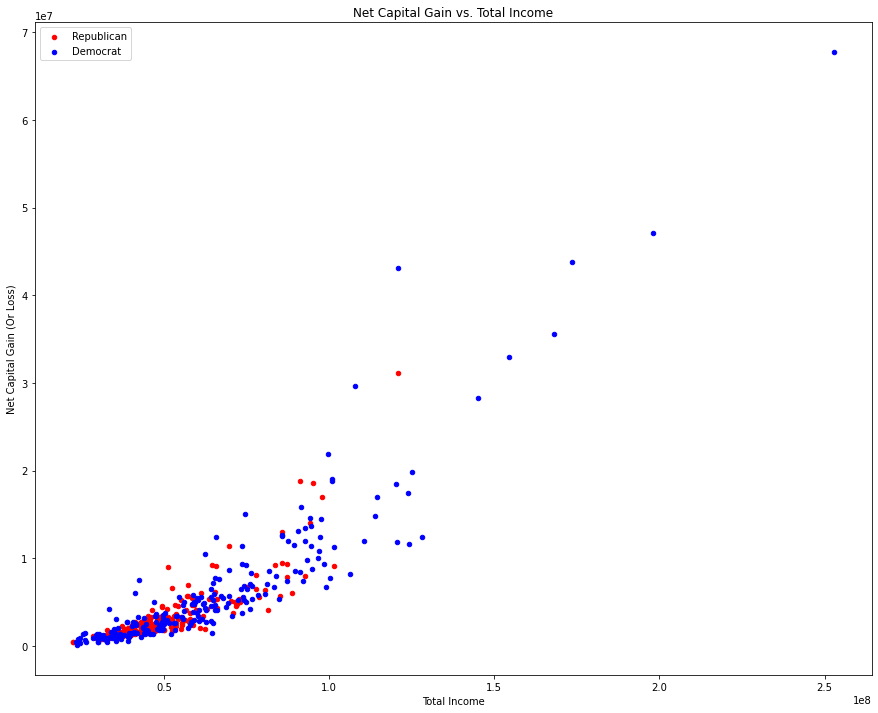

In [35]:
R = agg_data[agg_data['Party'].str.contains('R')]
D = agg_data[agg_data['Party'].str.contains('D')]


fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='Total Income', y='Net Capital Gain (Or Loss)', c='red',label='Republican', ax=ax, title = 'Net Capital Gain vs. Total Income')
D.plot.scatter(x='Total Income', y='Net Capital Gain (Or Loss)',c='blue',label='Democrat', ax=ax)


plt.legend()
plt.show()

# Analysis of 1st Hypothesis:

As income increases, Net Capital Gain in each district exponentially increases. This is especially shown in Democratic districts. On average, it appears that for larger income areas, Capital Gains from investments are larger as well. Comparing the Democratic and Republican districts, we can see that they both follow a similar distribution but there are many more Democratic districts in the high income & high net capital gain portion of the graph. This indicates that Democrats would on average slightly beat Republicans in investment performance. 

# PLOT 2 : Scatterplot of COVID Unemployment Compensation vs Total Income by Party

COVID Unemployment Compensation Amount ($) vs. Total District Income

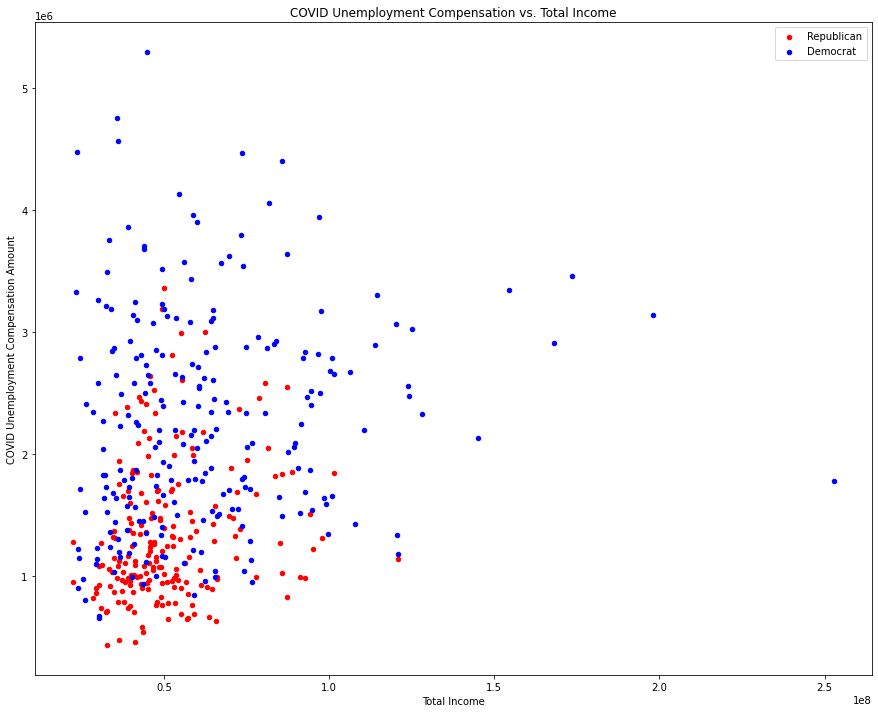

In [36]:
R = agg_data[agg_data['Party'].str.contains('R')]
D = agg_data[agg_data['Party'].str.contains('D')]


fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='Total Income', y="COVID Unemployment Compensation Amount", c='red',label='Republican', ax=ax,  title = 'COVID Unemployment Compensation vs. Total Income')
D.plot.scatter(x='Total Income', y="COVID Unemployment Compensation Amount",c='blue',label='Democrat', ax=ax)


plt.legend()
plt.show()

# Analysis of 2nd Hypothesis:

Interestingly enough, as Total District income increased, the amount of COVID unemployment compensation also increased. This Unemployment Compensation was greater in Low income areas for Democratic districts. The compensation was also greater in High income areas for Democratic districts. In Plot 2 we can observe a positive correlation between Total Income and Unemployment Benefits amongst Democratic districts, along with low-income Democratic districts having extremely high unemployment benefits relative to Republican districts. 

# PLOT 3: Boxplot of Net Capital Gain by Party

In [46]:
filtered_data = agg_data[agg_data["Party"] == "D"]

max_index = filtered_data["Net Capital Gain (Or Loss)"].idxmax()


filtered_data = filtered_data.drop(max_index)

agg_data = pd.concat([filtered_data, agg_data[agg_data["Party"] != "D"]])

Removed an outlier from the Democratic column to better show the distribution differences in Net Capital Gain between the parties. 

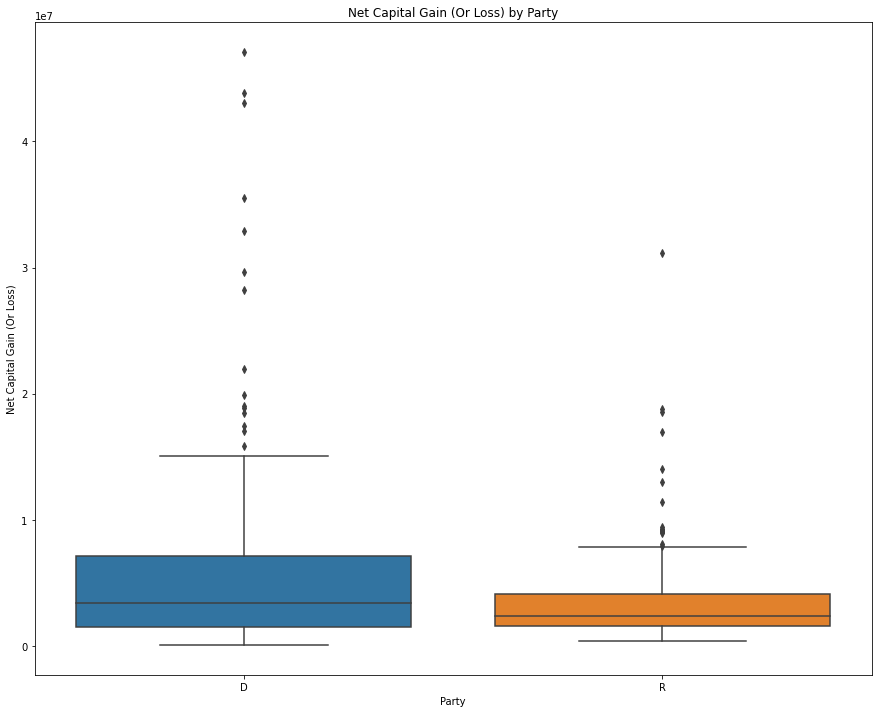

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 12))

sns.boxplot(x="Party", y="Net Capital Gain (Or Loss)", data=agg_data)

plt.title("Net Capital Gain (Or Loss) by Party")


plt.show()


# Statistical Analysis for Capital Gain difference between Republicans and Democrats


In [49]:
from scipy.stats import ttest_ind
import pandas as pd

data = agg_data

group1 = data[data["Party"] == "D"]["Net Capital Gain (Or Loss)"]
group2 = data[data["Party"] == "R"]["Net Capital Gain (Or Loss)"]


t_stat, p_value = ttest_ind(group1, group2)

if p_value < 0.05:
    print("The difference of mean Capital Gain between Republicans and Democrats is statistically significant (p = {})".format(p_value))
else:
    print("The difference of mean Capital Gain between Republicans and Democrats is not statistically significant (p = {})".format(p_value))


The difference of mean Capital Gain between Republicans and Democrats is statistically significant (p = 2.1886608771206043e-05)


# PLOT 4: Boxplot of COVID Unemployment Benefits by Party

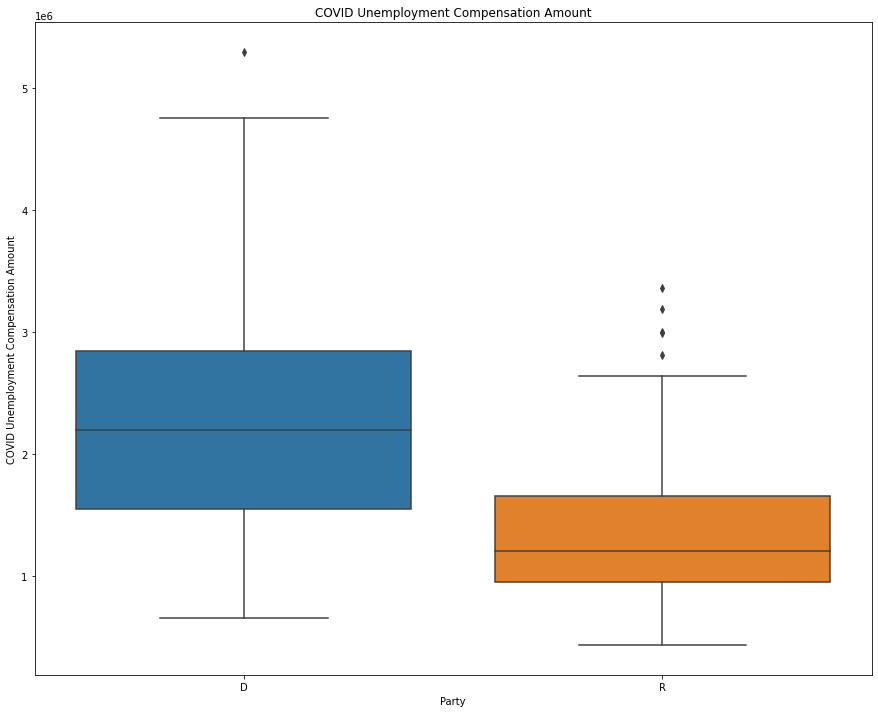

In [48]:
fig, ax = plt.subplots(figsize=(15, 12))

sns.boxplot(x="Party", y="COVID Unemployment Compensation Amount", data=agg_data)


plt.title("COVID Unemployment Compensation Amount")

plt.show()


# Statistical Analysis for difference in COVID Unemployment Benefit between Republicans and Democrats

In [32]:
from scipy.stats import ttest_ind
import pandas as pd

data = agg_data

group1 = data[data["Party"] == "D"]["COVID Unemployment Compensation Amount"]
group2 = data[data["Party"] == "R"]["COVID Unemployment Compensation Amount"]

t_stat, p_value = ttest_ind(group1, group2)

if p_value < 0.05:
    print("The difference of mean COVID Unemployment Benefit between Republicans and Democrats is statistically significant (p = {})".format(p_value))
else:
    print("The difference of mean COVID Unemployment Benefit between Republicans and Democrats is not statistically significant (p = {})".format(p_value))


The difference of mean COVID Unemployment Benefit between Republicans and Democrats is statistically significant (p = 8.96084396390195e-31)


# Conclusion:

We initially predicted that Democrats and Republicans were equally profitable investors, and that Democrats and Republicans would receive the same amount of unemployment benefits on average. After further analysis, we reject our initial hypotheses with evidence from our congressional district data and conclude that Democrats are more profitable investors than Republicans on average, and that Democrats generally received more unemployment benefits than Republicans on average. Our statistical analysis confirms our conclusions that Republicans and Democrats have different average Net Capital Gains, as well as having different amounts of COVID Unemployment Benefits. 

# Sources

IRS Data:

https://www.irs.gov/pub/irs-soi/20incd.csv